In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from edges_cal.modelling import Model, ModelFit
from edges_cal.xrfi import xrfi_model
from typing import Tuple

import warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def xrfi_2d_model(
    spectrum: np.ndarray,
    model_type: [str, Model] = "polynomial2d",
    flags: [None, np.ndarray] = None,
    f_ratio: [None, float] = None,
    f_log: bool = False,
    t_log: bool = True,
    n_signal: Tuple[int,int] = (3,3),
    n_resid: Tuple[int,int] = (-1,-1),
    threshold: float = 10,
    max_iter: int = 20,
    accumulate: bool = False,
    increase_order: bool = True,
    decrement_threshold: float = 0,
    min_threshold: float = 5,
    return_models: bool = False,
    inplace: bool = True,
    watershed: [None, int, Tuple[int, int, float], np.ndarray] = None,
):
    """
    Flag RFI by subtracting a smooth 2D model and iteratively removing outliers.

    On each iteration, a polynomial is fit to the unflagged data -- over both time and
    frequency, and a lower-order polynomial is fit to the absolute residuals of the data
    with the model polynomial. Bins with absolute residuals greater than
    `n_abs_resid_threshold` are flagged, and the process is repeated until no new flags
    are found.

    Parameters
    ----------
    spectrum
        A 2D array, shape (Nt, Nf). The data measured at those frequencies.
    model_type
        A model to fit to the data. Any :class:`Model` is accepted.
    flags
        The flags associated with the data (same shape as `spectrum`).
    f_ratio
        The ratio of the max to min frequency to be fit. Only required if ``f_log``
        is True.
    f_log
        Whether to fit the signal with log-spaced frequency values.
    t_log
        Whether to fit the signal with log temperature.
    n_signal
        The number of polynomial terms to use to fit the signal.
    n_resid
        The number of polynomial terms to use to fit the residuals.
    threshold
        The factor by which the absolute residual model is multiplied to determine
        outliers.
    max_iter
        The maximum number of iterations to perform.
    accumulate
        Whether to accumulate flags on each iteration.
    increase_order
        Whether to increase the order of the polynomial on each iteration.
    decrement_threshold
        An amount to decrement the threshold by every iteration. Threshold will never
        go below ``min_threshold``.
    min_threshold
        The minimum threshold to decrement to.
    return_models
        Whether to return the full models at each iteration.
    inplace
        Whether to fill up given flags array with the updated flags.
    watershed
        Specify a scheme for identifying channels surrounding a flagged channel as RFI.
        If an int, that many channels on each side of the flagged channel will be flagged.
        If a tuple, should be (int, float), where the int specifies the number of channels
        on each side, and the float specifies a threshold *with respect to* the overall
        threshold for flagging (so this should be less than one). If an array, the values
        represent this threshold where the central bin of the array is placed on the
        flagged channel.

    Returns
    -------
    flags : array-like
        Boolean array of the same shape as ``spectrum`` indicated which channels/times
        have flagged RFI.
    """
    if decrement_threshold > 0 and min_threshold > threshold:
        warnings.warn(
            f"You've set a threshold smaller than the min_threshold of {min_threshold}. "
            f"Will use threshold={min_threshold}."
        )
        threshold = min_threshold

    if f_log and not f_ratio:
        raise ValueError("If fitting in log(freq), you must provide f_ratio.")

    assert threshold > 1.5

    nt, nf = spectrum.shape
    f = np.linspace(-1, 1, nf) if not f_log else np.logspace(0, f_ratio, nf)
    times = np.linspace(-1, 1, nt)
    F, T = np.meshgrid(f, times)

    # Initialize some flags, or set them equal to the input
    orig_flags = flags if flags is not None else np.zeros((nt,nf), dtype=bool)
    orig_flags |= (spectrum <= 0) | np.isnan(spectrum) | np.isinf(spectrum)

    flags = orig_flags.copy()

    # We assume the residuals are smoother than the signal itself
    if not increase_order:
        assert n_resid <= n_signal

    # Set the watershed as a small array that will overlay a flag.
    if isinstance(watershed, int):
        # By default, just kill all surrounding channels (in a square)
        watershed = np.zeros((watershed * 2 + 1, watershed * 2 + 1))
        watershed[len(watershed) // 2, len(watershed) // 2] = 1
    elif watershed is not None and len(watershed) == 2:
        # Otherwise, can provide weights per-channel.
        watershed = np.ones((watershed[0] * 2 + 1, watershed[1] * 2 + 1)) * watershed[2]
    elif watershed is not None:
        assert watershed.ndim == 2

    n_flags_changed = 1
    counter = 0

    # Set up a few lists that we can update on each iteration to return info to the user.
    n_flags_changed_list = []
    total_flags_list = []
    model_list = []
    model_std_list = []

    # Iterate until either no flags are changed between iterations, or we get to the
    # requested maximum iterations, or until we have too few unflagged data to fit appropriately.
    while n_flags_changed > 0 and counter < max_iter and np.all(np.sum(~flags, axis=0) > n_signal[1] * 2) and np.all(np.sum(~flags, axis=1) > n_signal[0] * 2):
        # Only use un-flagged entries in our fit.
        ff = F[~flags].flatten()
        tt = T[~flags].flatten()
        s = spectrum[~flags]

        if t_log:
            s = np.log(s)

        # Get a model fit to the unflagged data.
        # Could be polynomial or fourier (or something else...)
        mdl = ModelFit(model_type, xdata=(ff, tt), ydata=s, n_terms=n_signal)
        par = mdl.model_parameters
        model = mdl.evaluate((F.flatten(), T.flatten()))

        if return_models:
            model_list.append(par)

        # Need to get back to linear space if we logged.
        if t_log:
            model = np.exp(model)

        res = spectrum - model.reshape(spectrum.shape)

        # Now fit a model to the absolute residuals.
        # This number is "like" a local standard deviation, since the polynomial does
        # something like a local average.
        mdl = ModelFit(
            model_type,
            xdata=(ff, tt),
            ydata=np.abs(res[~flags]),
            n_terms=(
                n_resid[0] if n_resid[0] > 0 else n_signal[0] + n_resid[0],
                n_resid[1] if n_resid[1] > 0 else n_signal[1] + n_resid[1],
            )
        )
        par = mdl.model_parameters
        model_std = mdl.evaluate((F.flatten(), T.flatten())).reshape(spectrum.shape)

        if return_models:
            model_std_list.append(par)

        if accumulate:
            # If we are accumulating flags, we just get the *new* flags and add them
            # to the original flags
            nflags = np.sum(flags[~flags])
            flags[~flags] |= np.abs(res)[~flags] > threshold * model_std[~flags]
            n_flags_changed = np.sum(flags[~flags]) - nflags
        else:
            # If we're not accumulating, we just take these flags (along with the fully
            # original flags).
            new_flags = orig_flags | (np.abs(res) > threshold * model_std)

            # Apply a watershed -- assume surrounding channels will succumb to RFI.
            if watershed is not None:
                watershed_flags = np.zeros_like(new_flags)
                # Go through each flagged channel
                for channel in np.where(new_flags)[0]:
                    rng = range(
                        max(0, channel - len(watershed) // 2),
                        min(len(new_flags), channel + len(watershed) // 2 + 1),
                    )
                    wrng_min = max(0, -(channel - len(watershed) // 2))
                    wrng = range(wrng_min, wrng_min + len(rng))

                    watershed_flags[rng] |= (
                        np.abs(res[rng]) > watershed[wrng] * threshold * model_std[rng]
                    )
                new_flags |= watershed_flags

            n_flags_changed = np.sum(flags ^ new_flags)
            flags = new_flags.copy()

        counter += 1
        if increase_order:
            n_signal = (n_signal[0]+1, n_signal[1]+1)

        # decrease the flagging threshold if we want to for next iteration
        threshold = max(threshold - decrement_threshold, min_threshold)

        # Append info to lists for the user's benefit
        n_flags_changed_list.append(n_flags_changed)
        total_flags_list.append(np.sum(flags))

    if counter == max_iter:
        warnings.warn(
            f"max iterations ({max_iter}) reached, not all RFI might have been caught."
        )

    if np.any(np.sum(~flags, axis=0) <= n_signal[1] * 2) or np.any(np.sum(~flags, axis=1) <= n_signal[0] * 2):
        warnings.warn(
            "Termination of iterative loop due to too many flags. Reduce n_signal or check data."
        )

    if inplace:
        orig_flags |= flags

    return (
        flags,
        {
            "n_flags_changed": n_flags_changed_list,
            "total_flags": total_flags_list,
            "models": model_list,
            "model_std": model_std_list,
            "n_iters": counter,
        },
    )


In [16]:
NFREQ, NTIME = 1000, 100

In [17]:
freq = np.linspace(50, 150, NFREQ)
sky_pl_1d = 1750 * (freq / 75.0) ** -2.55
sky_pl_2d = np.outer(np.linspace(5, 6, NTIME), sky_pl_1d)
rfi_bins = np.random.binomial(1, 0.05, size=(NTIME, NFREQ))


In [18]:
def thermal_noise(spec, scale=1, seed=None):
    if seed:
        np.random.seed(seed)
    return np.random.normal(0, spec / scale)

In [19]:
scale = 1000
std = sky_pl_2d / scale
amp = std.max() * 500
noise = thermal_noise(sky_pl_2d, scale=scale, seed=1010)
rfi = rfi_bins * amp
sky = sky_pl_2d + noise + rfi

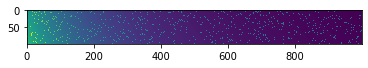

In [20]:
plt.imshow(sky)

In [44]:
%%timeit

for s in sky:
    flags, info = xrfi_model(s, n_signal=8)

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.86061e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.88132e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.56486e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.70604e-22): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.16727e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.48341e-50): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.67051e-48): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.12082e-52): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.09259e-50): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.59273e-55): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.19134e-46): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.4372e-44): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=8.8735e-49): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.15659e-46): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.8915e-51): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/r

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.41659e-55): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.8618e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.76335e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.26114e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.23888e-22): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.15435e-22): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=3.37804e-27): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.90214e-25): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.32047e-29): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=3.46366e-27): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=3.23662e-40): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.30811e-44): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.03126e-42): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.41367e-47): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.15237e-44): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=8.9913e-34): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.51783e-31): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.02496e-35): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.03094e-33): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.29613e-38): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=9.69408e-27): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.87919e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.55021e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.19629e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.45944e-22): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.09733e-37): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.21217e-42): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=7.27748e-40): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.25106e-44): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.5162e-42): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=7.73026e-36): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.50513e-33): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.11357e-38): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=6.74865e-36): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.49541e-40): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=6.25283e-58): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=7.93799e-56): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.8732e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.40664e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=3.18648e-18): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.79106e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=7.87054e-25): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.23217e-22): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.31392e-27): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.12522e-24): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.83785e-38): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.39143e-36): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.74801e-40): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.82426e-38): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.12214e-42): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Project

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=9.0119e-23): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=2.07394e-20): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.4342e-25): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.01525e-23): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=5.39679e-27): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/

/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=3.87714e-34): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=9.38541e-39): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=1.59398e-36): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=4.4569e-41): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/modelling.py:367: LinAlgWarning: Ill-conditioned matrix (rcond=9.25998e-39): result may not be accurate.
  q, r = self.qr
/home/steven/Documents/Projects

2.51 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit

flags, info = xrfi_2d_model(sky, n_signal=(8,3))

3.72 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


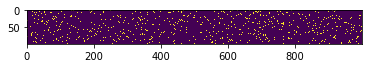

In [32]:
plt.imshow(flags)

In [33]:
np.sum(flags)

5019

In [36]:
true_flags = rfi_bins > 0

In [38]:
np.sum(true_flags)

5019

In [37]:
np.where(true_flags & ~flags)[0]

array([], dtype=int64)

In [34]:
info

{'n_flags_changed': [4980, 20199, 22013, 5793, 0],
 'total_flags': [4980, 25179, 10812, 5019, 5019],
 'models': [],
 'model_std': [],
 'n_iters': 5}